In [1]:
import pandas as pd

# df = pd.read_parquet("data/eurosat_rgb/initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df


,filename,filepath,label
0,AnnualCrop_2216.tif,data/eurosat_rgb/0/AnnualCrop_2216.jpg,Annual Crop
1,AnnualCrop_1331.tif,data/eurosat_rgb/0/AnnualCrop_1331.jpg,Annual Crop
2,AnnualCrop_631.tif,data/eurosat_rgb/0/AnnualCrop_631.jpg,Annual Crop
3,AnnualCrop_2904.tif,data/eurosat_rgb/0/AnnualCrop_2904.jpg,Annual Crop
4,AnnualCrop_1963.tif,data/eurosat_rgb/0/AnnualCrop_1963.jpg,Annual Crop
...,...,...,...
883,None,data/eurosat_rgb/9/SeaLake_466.jpg,SeaLake
884,None,data/eurosat_rgb/0/AnnualCrop_2045.jpg,Annual Crop
885,None,data/eurosat_rgb/0/AnnualCrop_1436.jpg,Annual Crop
886,None,data/eurosat_rgb/8/River_1624.jpg,River


In [2]:
df["label"].value_counts()

label
Herbaceous Vegetation    146
Highway                  120
Permanent Crop           112
Annual Crop              108
Pasture                  103
River                    101
SeaLake                   62
Forest                    54
Industrial Buildings      42
Residential Buildings     40
Name: count, dtype: int64

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18
from fastai.vision.all import aug_transforms

al = ActiveLearner(resnet18)

2025-01-22 13:04:45.037 | INFO     | active_vision.core:load_model:39 - Loading fastai model resnet18


In [4]:
al.load_dataset(df, filepath_col="filepath", label_col="label", 
                batch_size=16,
                image_size=64,
                batch_tfms=aug_transforms(size=64))

2025-01-22 13:04:45.043 | INFO     | active_vision.core:load_dataset:57 - Loading dataset from filepath and label
2025-01-22 13:04:45.044 | INFO     | active_vision.core:load_dataset:60 - Creating dataloaders
2025-01-22 13:04:45.405 | INFO     | active_vision.core:load_dataset:82 - Creating learner
2025-01-22 13:04:45.536 | INFO     | active_vision.core:load_dataset:89 - Done. Ready to train.


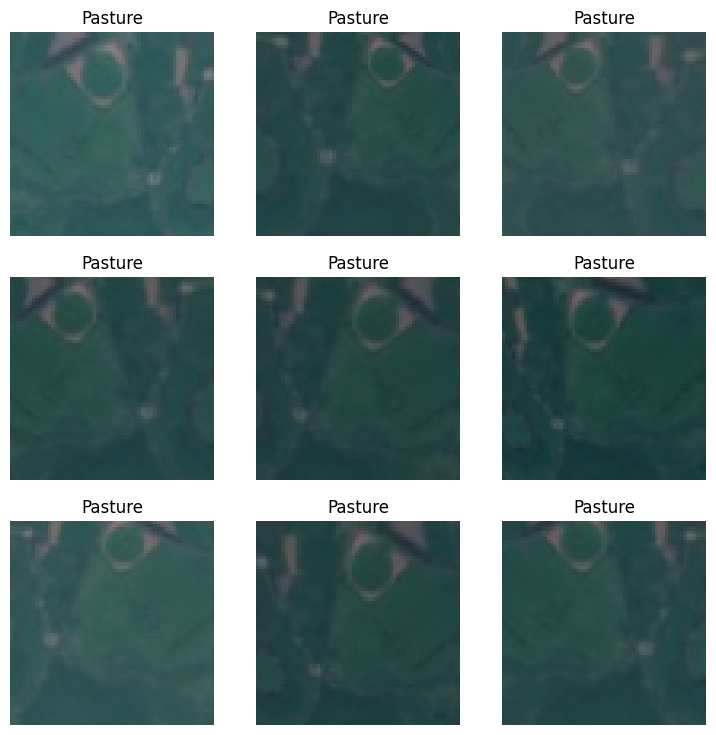

In [5]:
al.show_batch(unique=True)

In [6]:
# al.train_set

In [7]:
# al.lr_find()

2025-01-22 13:04:45.968 | INFO     | active_vision.core:train:125 - Training head for 3 epochs
2025-01-22 13:04:45.969 | INFO     | active_vision.core:train:126 - Training model end-to-end for 10 epochs
2025-01-22 13:04:45.969 | INFO     | active_vision.core:train:127 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,3.036459,2.095444,0.333333,00:02
1,2.520550,1.866680,0.429379,00:02
2,2.260876,2.087885,0.423729,00:02


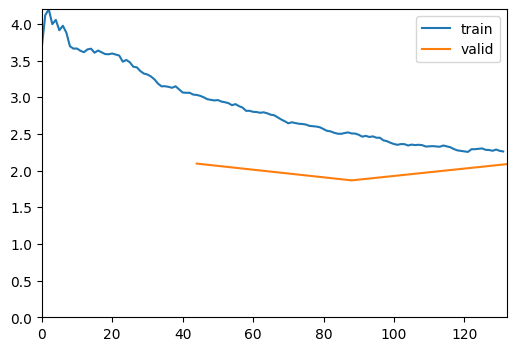

epoch,train_loss,valid_loss,accuracy,time
0,1.889158,1.870166,0.457627,00:02
1,1.680672,1.566417,0.548023,00:02
2,1.484672,2.044858,0.480226,00:04
3,1.307247,1.494527,0.559322,00:03
4,1.213590,1.367796,0.598870,00:03
5,1.003727,1.089411,0.661017,00:03
6,0.845993,1.074652,0.655367,00:03
7,0.673079,0.997636,0.666667,00:03
8,0.543352,1.017826,0.700565,00:03
9,0.475239,0.986390,0.694915,00:03


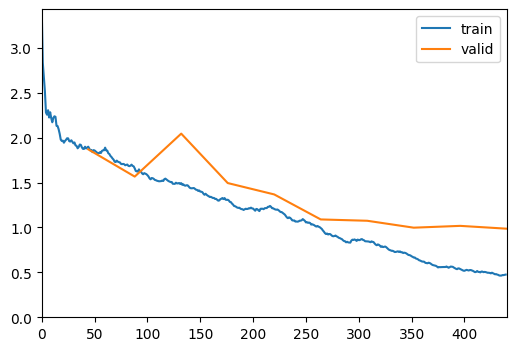

In [8]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate the model on a *labeled* evaluation set

In [9]:
evaluation_df = pd.read_parquet("data/eurosat_rgb/evaluation_samples.parquet")
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")


2025-01-22 13:05:29.998 | INFO     | active_vision.core:evaluate:172 - Accuracy: 89.80%


0.897962962962963

## Get the predictions from an *unlabeled* set

In [10]:
df = pd.read_parquet("data/eurosat_rgb/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

16100

In [11]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-22 13:05:30.023 | INFO     | active_vision.core:predict:136 - Running inference on 16100 samples


,filepath,pred_label,pred_conf,pred_raw
0,data/eurosat_rgb/0/AnnualCrop_1.jpg,Annual Crop,0.778448,"[0.7784482836723328, 0.00013788029900752008, 0.00022522696235682815, 1.2047846212226432e-05, 0.00013923339429311454, 0.001261131837964058, 0.21957141160964966, 3.365729207871482e-05, 7.995501073310152e-05, 9.113331907428801e-05]"
1,data/eurosat_rgb/0/AnnualCrop_10.jpg,Annual Crop,0.987951,"[0.9879507422447205, 5.758366114605451e-06, 7.2193748756888e-09, 9.888483987197105e-08, 2.1142511741345515e-06, 2.481484216332319e-06, 2.651073138792981e-08, 1.7633390598348342e-05, 0.004085122141987085, 0.00793603714555502]"
2,data/eurosat_rgb/0/AnnualCrop_100.jpg,Annual Crop,0.999522,"[0.9995220899581909, 6.093483989388915e-06, 3.52663801095332e-06, 5.103880539536476e-05, 1.2177656572021078e-05, 4.1458813939243555e-05, 0.00016777934797573835, 3.949647179979365e-06, 0.000170421481016092, 2.1540079615078866e-05]"
3,data/eurosat_rgb/0/AnnualCrop_1000.jpg,Annual Crop,0.999475,"[0.999474823474884, 1.402733346367313e-06, 1.7400330762029625e-05, 2.3329112082137726e-05, 1.0860674137802562e-06, 1.4397232916962821e-05, 0.0004600759129971266, 9.325985956820659e-07, 4.102780621906277e-06, 2.4763410237937933e-06]"
4,data/eurosat_rgb/0/AnnualCrop_1001.jpg,Annual Crop,0.968670,"[0.9686702489852905, 1.7388271089657792e-06, 7.164062481024303e-07, 1.0861690498131793e-05, 0.001948266290128231, 0.0005378532805480063, 0.02868553437292576, 1.8621271010488272e-05, 5.8717745559988543e-05, 6.758371455362067e-05]"
...,...,...,...,...
16095,data/eurosat_rgb/9/SeaLake_993.jpg,SeaLake,0.999751,"[0.0001012908251141198, 3.102800837950781e-05, 7.152456760195491e-07, 1.6498081834015466e-07, 5.972051076241769e-05, 2.363593921472784e-06, 2.1686319939817622e-07, 1.721076296234969e-05, 3.6328594433143735e-05, 0.9997509121894836]"
16096,data/eurosat_rgb/9/SeaLake_994.jpg,SeaLake,0.999892,"[7.440646004397422e-05, 1.5255204743880313e-06, 3.7543532727113416e-08, 6.057410129045593e-09, 2.8742326321662404e-05, 1.1886568245245144e-06, 8.901299253238903e-08, 1.5465204796782928e-06, 8.687910622029449e-07, 0.9998915195465088]"
16097,data/eurosat_rgb/9/SeaLake_995.jpg,SeaLake,0.999946,"[2.6687806894187815e-05, 5.946138116996735e-06, 1.0716652809605876e-07, 8.1198017198858e-09, 1.6061005226220004e-05, 1.0378346360084834e-06, 9.512989862514587e-08, 2.3646330191695597e-06, 1.50195171499945e-06, 0.9999462366104126]"
16098,data/eurosat_rgb/9/SeaLake_996.jpg,SeaLake,0.999780,"[5.038947711000219e-05, 8.869574958225712e-05, 8.849626738083316e-07, 3.7539329866831395e-08, 5.593971218331717e-05, 3.4090135159203783e-06, 2.237536023130815e-07, 1.1325371815473773e-05, 9.410291568201501e-06, 0.9997796416282654]"


In [12]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=100)
uncertain_df

2025-01-22 13:05:34.187 | INFO     | active_vision.core:sample_uncertain:194 - Getting top 100 low confidence samples


,filepath,pred_label,pred_conf,pred_raw,uncertainty_score
4223,data/eurosat_rgb/2/HerbaceousVegetation_1999.jpg,River,0.243696,"[0.006545208860188723, 0.006468954961746931, 0.15257543325424194, 0.028058728203177452, 0.006006221286952496, 0.19429124891757965, 0.10914728045463562, 0.20301982760429382, 0.24369582533836365, 0.050191350281238556]",0.756304
4233,data/eurosat_rgb/2/HerbaceousVegetation_2016.jpg,Highway,0.253896,"[0.014923539012670517, 0.06033500283956528, 0.25340044498443604, 0.2538958489894867, 0.00328467576764524, 0.007504026871174574, 0.042146336287260056, 0.04055648297071457, 0.20045624673366547, 0.12349751591682434]",0.746104
15266,data/eurosat_rgb/9/SeaLake_2451.jpg,River,0.258110,"[0.04377095028758049, 0.18089479207992554, 0.04178692772984505, 0.11487150192260742, 0.053147025406360626, 0.08837658911943436, 0.0010243799770250916, 0.05347239971160889, 0.2581096291542053, 0.16454581916332245]",0.741890
6767,data/eurosat_rgb/3/Highway_879.jpg,Herbaceous Vegetation,0.271034,"[0.014238586649298668, 0.06768019497394562, 0.2710341215133667, 0.165518119931221, 0.0034051588736474514, 0.03138979896903038, 0.11657033115625381, 0.1410232037305832, 0.16184186935424805, 0.02729857712984085]",0.728966
7818,data/eurosat_rgb/4/Industrial_2468.jpg,Pasture,0.273726,"[0.01597953960299492, 0.004582687746733427, 0.02834785357117653, 0.23027582466602325, 0.26144683361053467, 0.2737264931201935, 0.13005907833576202, 0.004737401381134987, 0.03080136701464653, 0.02004283294081688]",0.726274
...,...,...,...,...,...
7649,data/eurosat_rgb/4/Industrial_2206.jpg,Industrial Buildings,0.411064,"[0.002238618675619364, 0.011110713705420494, 0.00428147055208683, 0.004513310734182596, 0.4110642969608307, 0.0013524973765015602, 0.24071012437343597, 0.2897852957248688, 0.03010634519159794, 0.004837349057197571]",0.588936
10715,data/eurosat_rgb/6/PermanentCrop_607.jpg,Herbaceous Vegetation,0.411101,"[0.12175867706537247, 0.0006049276562407613, 0.4111005961894989, 0.05221456289291382, 0.0003830163332168013, 0.015460995025932789, 0.3877047896385193, 0.002243193332105875, 0.0027645693626254797, 0.0057646711356937885]",0.588899
1531,data/eurosat_rgb/0/AnnualCrop_621.jpg,Annual Crop,0.411635,"[0.41163530945777893, 0.05436517298221588, 0.04651235044002533, 0.035887159407138824, 0.05099659413099289, 0.009852408431470394, 0.3333524465560913, 0.023936660960316658, 0.023296697065234184, 0.010165156796574593]",0.588365
9627,data/eurosat_rgb/6/PermanentCrop_1157.jpg,Industrial Buildings,0.411638,"[0.022442679852247238, 1.958520442713052e-05, 1.1879026715178043e-05, 0.201401486992836, 0.41163793206214905, 8.117841935018077e-05, 0.3618529438972473, 2.0525118088698946e-05, 0.0025303238071501255, 1.4926539506632253e-06]",0.588362


## Label the uncertain samples

In [13]:
al.label(uncertain_df, output_filename="uncertain")

2025-01-22 13:05:35.719 | INFO     | active_vision.core:label:275 - Launching labeling interface for 100 samples


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [14]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


,filepath,label
0,data/eurosat_rgb/5/Pasture_1923.jpg,Pasture
1,data/eurosat_rgb/6/PermanentCrop_2202.jpg,Permanent Crop
2,data/eurosat_rgb/2/HerbaceousVegetation_1402.jpg,Herbaceous Vegetation
3,data/eurosat_rgb/2/HerbaceousVegetation_1445.jpg,Herbaceous Vegetation
4,data/eurosat_rgb/2/HerbaceousVegetation_1029.jpg,Herbaceous Vegetation
...,...,...
903,data/eurosat_rgb/4/Industrial_2206.jpg,Industrial Buildings
904,data/eurosat_rgb/6/PermanentCrop_607.jpg,Permanent Crop
905,data/eurosat_rgb/0/AnnualCrop_621.jpg,Annual Crop
906,data/eurosat_rgb/6/PermanentCrop_1157.jpg,Permanent Crop


In [15]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")

2025-01-22 13:10:07.333 | INFO     | active_vision.core:add_to_train_set:619 - Adding 888 samples to training set
2025-01-22 13:10:07.337 | INFO     | active_vision.core:add_to_train_set:628 - Saved training set to active_labeled.parquet
